In [1]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import scipy.stats as st

from itertools import product
from collections import namedtuple, defaultdict
from collections.abc import Iterable
from functools import reduce
from pathlib import Path

import matplotlib.pyplot as plt

def filter_experiments(experiments, mask):
    # Mask is a namedtuple that has None for fields that are to be ignored
    mask_base = set(filter(lambda y: not isinstance(y[1], tuple), 
                           filter(lambda x: x[1], mask._asdict().items())))
    mask_permutes = set(filter(lambda y: isinstance(y[1], tuple),
                              filter(lambda x: x[1], mask._asdict().items())))
    
    # Delta is the permuting parameter expansions
    delta = list(map(lambda x: set(product((x[0],), x[1])), mask_permutes))
    permutations = [x.union(mask_base) for x in list(map(lambda x: set(x), product(*delta)))]
    
    # All of the experiments that match the filter(s)
    exps = list(map(lambda x: set(filter(lambda y: x <= set(y._asdict().items()), experiments)), permutations))
    
    # Collapse all of the experiments into a set and return it
    return reduce(lambda x, y: x.union(y), exps)

def filter_anomalies(data):
    mean = np.mean(data)
    std = np.std(data)
    
    return [x for x in data if (mean - 2 * std) < x < (mean + 2 * std)]

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, h

def aggregate_results(results_dir):
    control_files = [x for x in os.listdir(str(results_dir)) if 'control_' in x]
    results_files = [x for x in os.listdir(str(results_dir)) if 'results_' in x]
    
    # Aggregate the control data
    control = {}
    for f in control_files:
        file_path = Path(results_dir, f)
        with open(str(file_path), 'rb') as handle:
            file_dict = pickle.load(handle)
            control.update(file_dict)
            
    # Aggregate the experiment results
    experiments = {}
    for f in results_files:
        file_path = Path(results_dir, f)
        with open(str(file_path), 'rb') as handle:
            file_dict = pickle.load(handle)
            experiments.update(file_dict)
            
    return control, experiments

In [2]:
def parse_control(file_path):
    # Parse the COOJA.testlog file
    logfile = open(file_path, 'r').readlines()
    end_tick_re = re.compile(r'^(?P<tick>\d+)\ all\ motes\ converged,\ closing\ sim$')
    end_tick = None

    for line in logfile:
        match = end_tick_re.match(line)

        if match:
            end_tick = int(match.group('tick'))

    return end_tick

In [11]:
def graph_data(x_key, y_key, results, control, exp_type, filter_params={}, 
               control_params=None, **kwargs):
    filter_params[x_key] = None  # Set the X value to none for X-axis
    
    if not control_params:
        control_params = dict([(key, None) for key in exp_type._fields])
    filtered_control = filter_experiments(control.keys(), exp_type(**control_params))
    processed_control = []
    for exp in filtered_control:
        exp_data = control[exp]
        exp_data = list(map(lambda x: float(x), 
                            filter(lambda x: x, map(lambda x: x.get(y_key), exp_data))))
        exp_mean, exp_ci = mean_confidence_interval(exp_data)
        
        processed_control.append((exp_mean, exp_ci))
    
    filtered_results = filter_experiments(results.keys(), exp_type(**filter_params))
    processed_results = []
    for exp in filtered_results:
        exp_data = results[exp]
        exp_data = list(map(lambda x: float(x), 
                            filter(lambda x: x, map(lambda x: x.get(y_key), exp_data))))
        exp_mean, exp_ci = mean_confidence_interval(exp_data)
        
        processed_results.append((getattr(exp, x_key), (exp_mean, exp_ci)))
    
    # Sort the x axis in ascending order
    processed_results = sorted(processed_results, key=lambda x: x[0])
    control_value = processed_control[0][0]
    
    # Graph the data
    figsize = kwargs.get('figsize', (15, 10))
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    
    x_axis, data = tuple(list(map(list, zip(*processed_results))))
    axes.set_xticks(x_axis)
    axes.grid(linestyle='--')
    axes.errorbar(x_axis, *list(map(list, zip(*data))),
                 marker='^', color='royalblue', ecolor='orange', capsize=4)
    axes.axhline(control_value, color='orangered', linestyle='--')
    # Config via. KWargs
    if kwargs.get('figtitle'):
        fig.suptitle(kwargs.get('figtitle'))
    if kwargs.get('xlabel'):
        axes.set_xlabel(kwargs.get('xlabel'))
    if kwargs.get('ylabel'):
        axes.set_ylabel(kwargs.get('ylabel'))
    if kwargs.get('title'):
        axes.set_title(kwargs.get('title'))
    if kwargs.get('ylim'):
        axes.set_ylim(*kwargs.get('ylim'))
    if kwargs.get('xlim'):
        axes.set_xlim(*kwargs.get('xlim'))
        
    # Control label padding
    left, right = axes.get_xlim()
    right_pad = 1 * ((right - left) / 100)
    bottom, _ = axes.get_ylim()
    top_pad = 1 * ((control_value - bottom) / 100)
    if kwargs.get('control_label'):
        axes.text(right - right_pad, control_value - top_pad, kwargs.get('control_label'), 
                  horizontalalignment='right', verticalalignment='top', color='red')
    else:
        axes.text(right - right_pad, control_value + - top_pad, 'Control', 
                  horizontalalignment='right', verticalalignment='top', color='red')
    # Save the file
    if kwargs.get('filename'):
        fig.savefig(fname=kwargs.get('filename'), dpi=150)

In [12]:
def graph_data_scatter(x_key, y_key, results, control, exp_type, filter_params={}, 
               control_params=None, **kwargs):
    filter_params[x_key] = None  # Set the X value to none for X-axis
    
    if not control_params:
        control_params = dict([(key, None) for key in exp_type._fields])
    filtered_control = filter_experiments(control.keys(), exp_type(**control_params))
    processed_control = []
    for exp in filtered_control:
        exp_data = control[exp]
        exp_data = list(map(lambda x: float(x), 
                            filter(lambda x: x, map(lambda x: x.get(y_key), exp_data))))
        exp_mean, exp_ci = mean_confidence_interval(exp_data)
        
        processed_control.append((exp_mean, exp_ci))
    
    filtered_results = filter_experiments(results.keys(), exp_type(**filter_params))
    processed_results = []
    for exp in filtered_results:
        exp_data = results[exp]
        exp_data = list(map(lambda x: float(x), 
                            filter(lambda x: x, map(lambda x: x.get(y_key), exp_data))))
        processed_results.append((getattr(exp, x_key), (exp_data)))
    
    # Sort the x axis in ascending order
    processed_results = sorted(processed_results, key=lambda x: x[0])
    control_value = processed_control[0][0]
    
    # Graph the data
    figsize = kwargs.get('figsize', (15, 10))
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    
    x_axis = []
    x_data = []
    y_data = []
    for x, y in processed_results:
        x_axis.append(x)
        x_data += ([x] * len(y))
        y_data += y
    
    x_ok = []
    x_anom = []
    y_ok = []
    y_anom = []
    
    data_dict = dict(processed_results)
    for index, val in enumerate(y_data):
        x = x_data[index]
        raw_data = data_dict[x]
        
        mean = np.mean(raw_data)
        std = np.std(raw_data)
    
        if (mean - 1 * std) < val < (mean + 1 * std):
            x_ok.append(x)
            y_ok.append(val)
        else:
            x_anom.append(x)
            y_anom.append(val)
            
        
    axes.set_xticks(x_axis)
    axes.grid(linestyle='--')
    axes.scatter(x_ok, y_ok, c='seagreen', label='within 1 std. dev')
    axes.scatter(x_anom, y_anom, c='orangered', label='outside 1 std. dev')
    axes.axhline(control_value, color='blue', linestyle='--')
    legend_loc = kwargs.get('legend_loc', 'upper left')
    axes.legend(loc=legend_loc)
    # Config via. KWargs
    if kwargs.get('figtitle'):
        fig.suptitle(kwargs.get('figtitle'))
    if kwargs.get('xlabel'):
        axes.set_xlabel(kwargs.get('xlabel'))
    if kwargs.get('ylabel'):
        axes.set_ylabel(kwargs.get('ylabel'))
    if kwargs.get('title'):
        axes.set_title(kwargs.get('title'))
    if kwargs.get('ylim'):
        axes.set_ylim(*kwargs.get('ylim'))
    if kwargs.get('xlim'):
        axes.set_xlim(*kwargs.get('xlim'))
    # Control label padding
    left, right = axes.get_xlim()
    right_pad = 1 * ((right - left) / 100)
    bottom, _ = axes.get_ylim()
    top_pad = 1 * ((control_value - bottom) / 100)
    if kwargs.get('control_label'):
        axes.text(right - right_pad, control_value + top_pad, kwargs.get('control_label'), 
                  horizontalalignment='right', verticalalignment='bottom', color='blue')
    else:
        axes.text(right - right_pad, control_value + top_pad, 'Control', 
                  horizontalalignment='right', verticalalignment='bottom', color='blue')
    # Save the file
    if kwargs.get('filename'):
        fig.savefig(fname=kwargs.get('filename'), dpi=150)

# Rime Multi-hop

In [16]:
RmhExperiment = namedtuple('RmhExperiment', ['d', 'n', 't'])

rmh_base_dir = Path('tpwsn-rmh/')
rmh_results_dir = Path(rmh_base_dir, 'results-21x21')
rmh_experiments_path = Path(rmh_results_dir, 'results_data.pickle')
rmh_control_path = Path(rmh_results_dir, 'control_data-grace-01.pickle')
rmh_graphs_dir = Path('graphs-21x21/rmh/')

rmh_control, rmh_experiments = aggregate_results(rmh_results_dir)
    
if not rmh_graphs_dir.exists():
    rmh_graphs_dir.mkdir(parents=True, exist_ok=True)
    
# Load other results from disk
rmh_control_raw_dir = Path(rmh_base_dir, 'control-exp')
rmh_stats_raw = [parse_control(str(Path(rmh_control_raw_dir, x, 'COOJA.testlog'))) for x in 
                 os.listdir(str(rmh_control_raw_dir))]
# Get the average end tick time
rmh_stats_raw = [x for x in rmh_stats_raw if x]
rmh_stats_raw += [x.get('end_tick') for x in rmh_control[RmhExperiment(d=0, n=0, t='none')]]

rmh_control_end_mean, rmh_control_end_ci = mean_confidence_interval(rmh_stats_raw)
rmh_control_end_mean/1e6, rmh_control_end_ci/1e6

(50.257872166666665, 25.94831240358248)

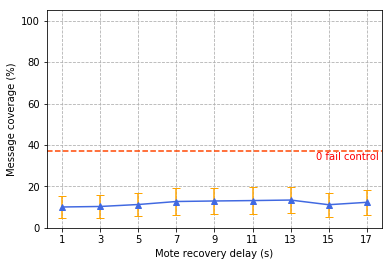

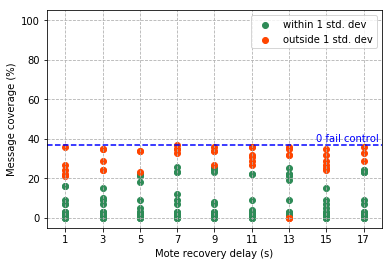

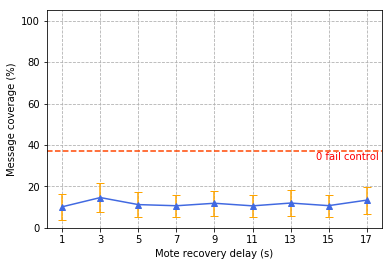

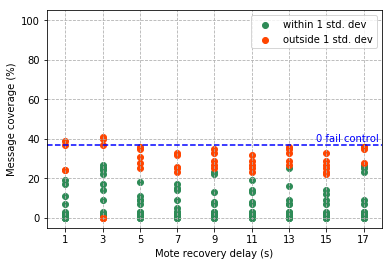

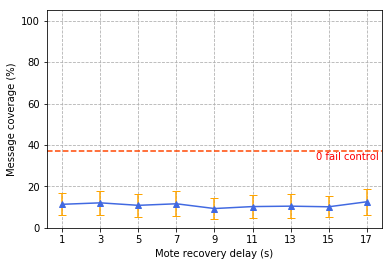

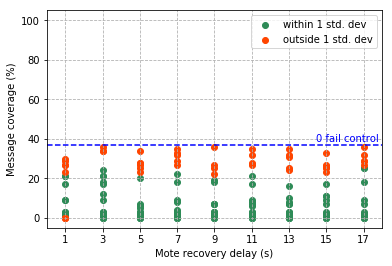

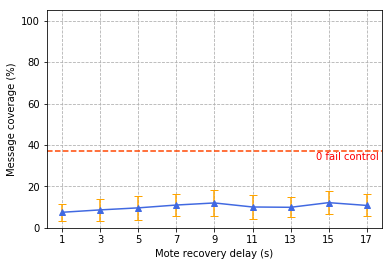

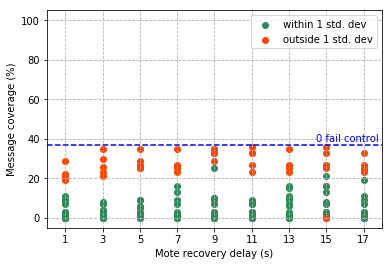

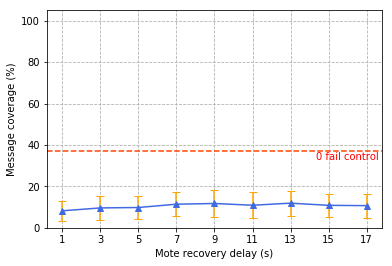

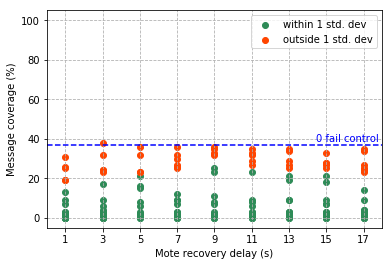

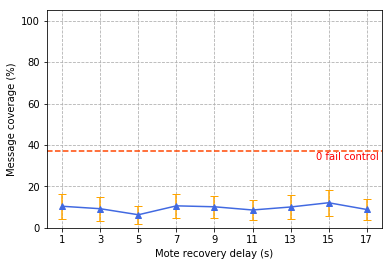

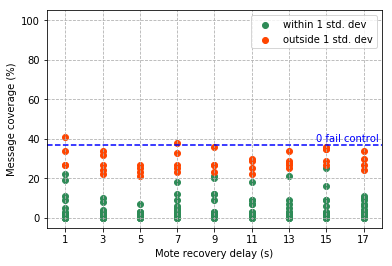

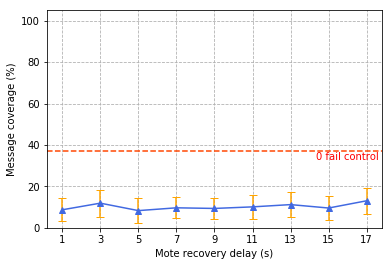

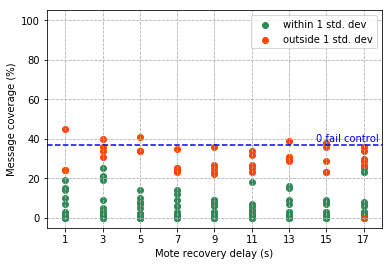

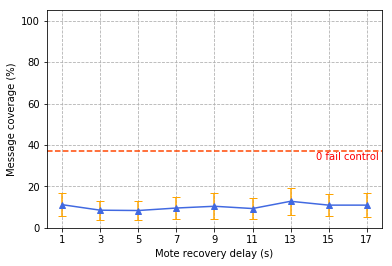

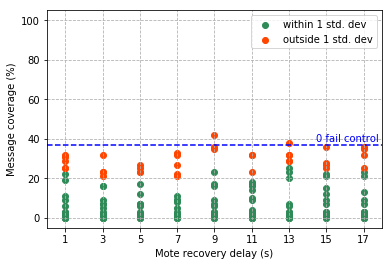

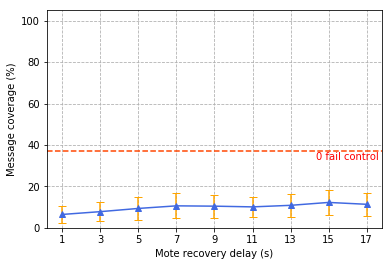

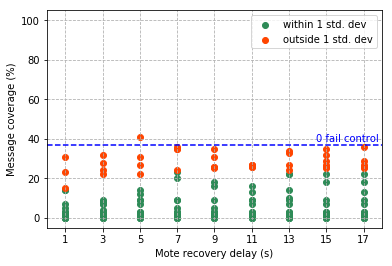

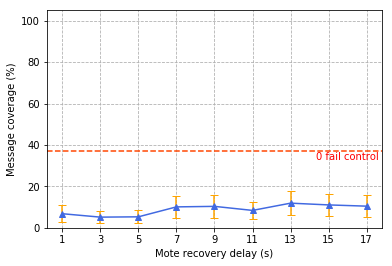

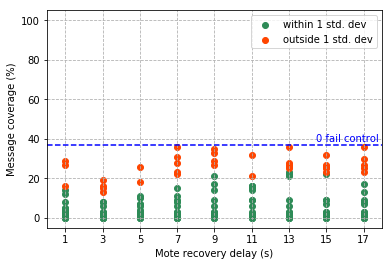

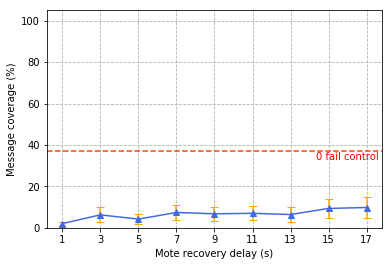

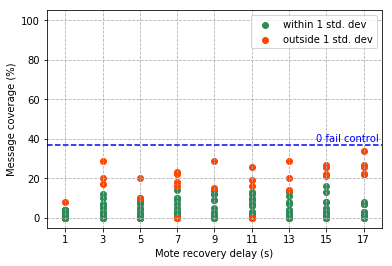

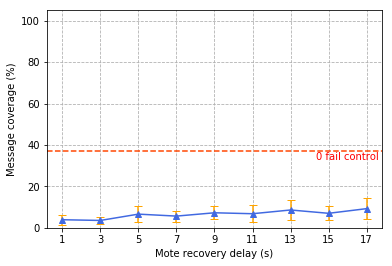

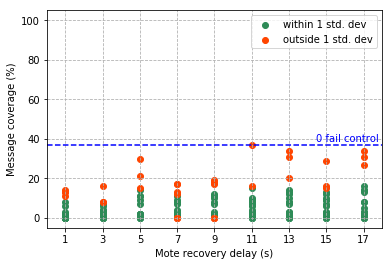

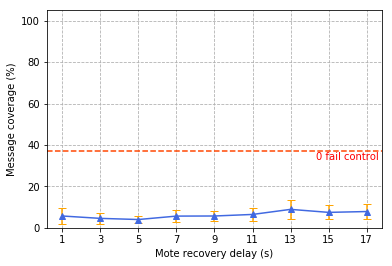

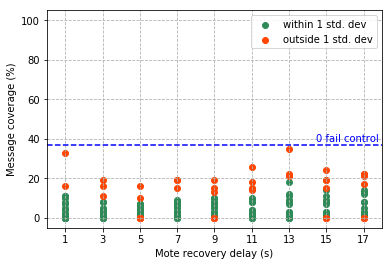

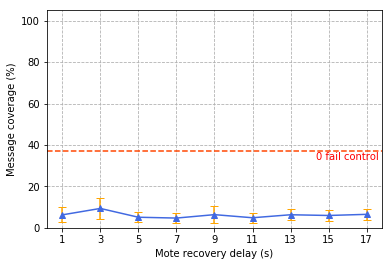

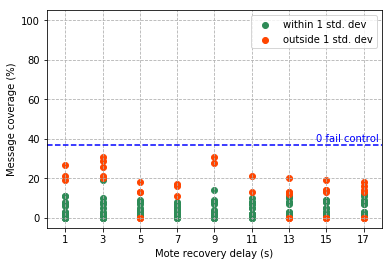

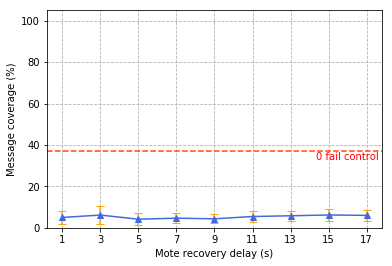

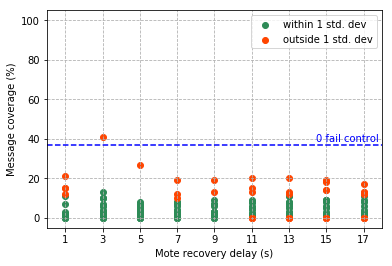

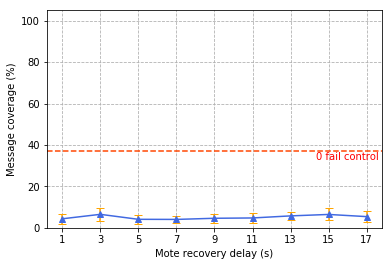

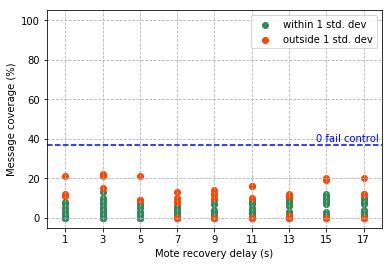

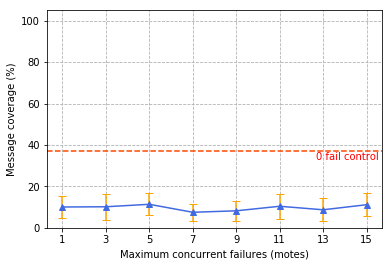

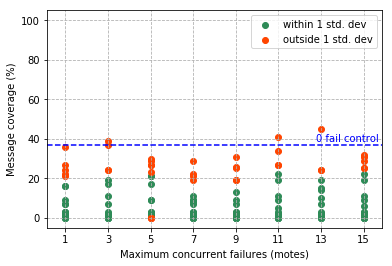

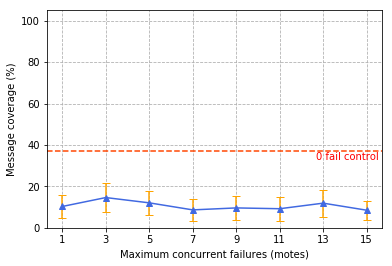

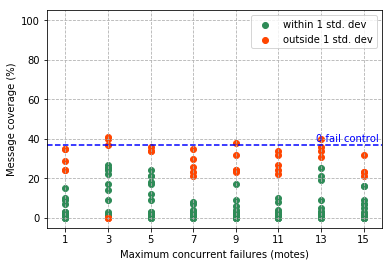

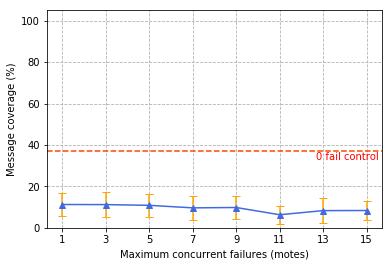

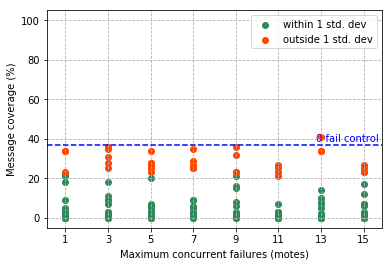

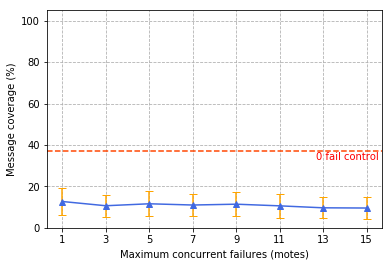

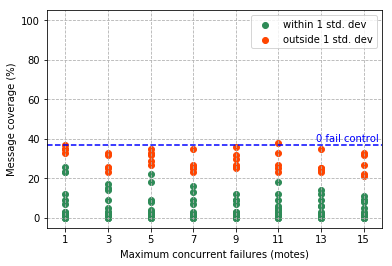

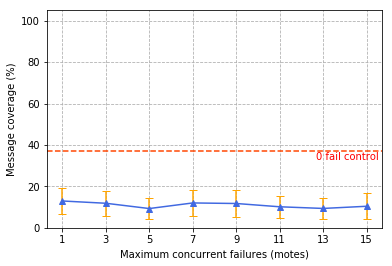

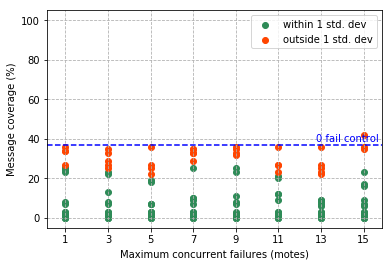

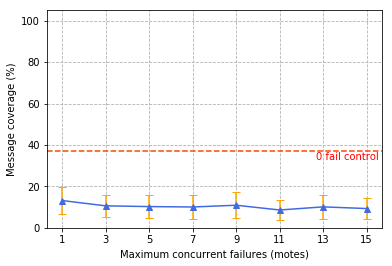

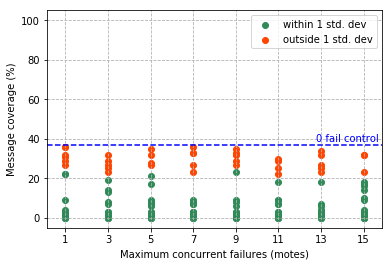

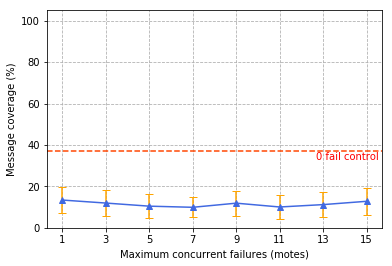

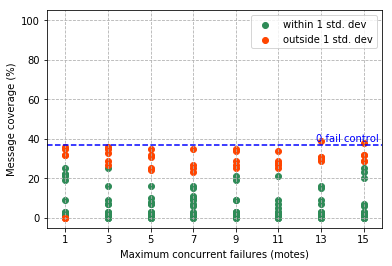

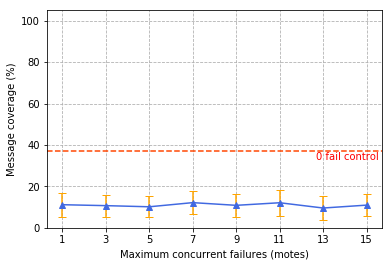

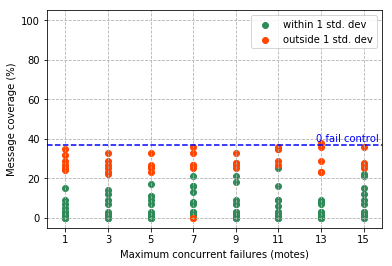

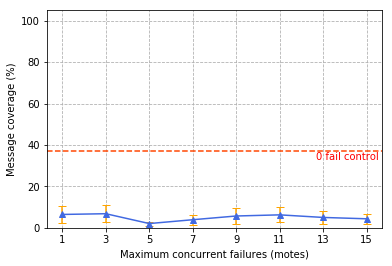

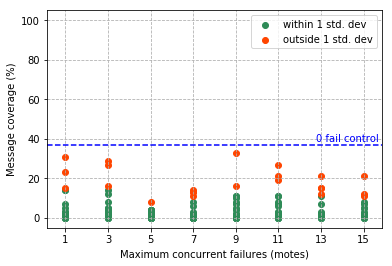

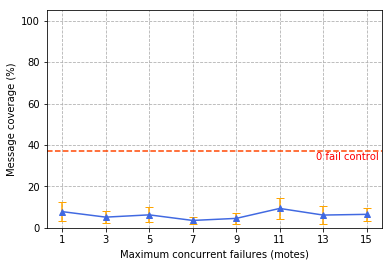

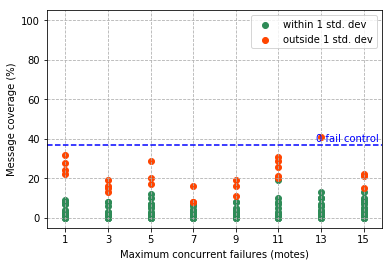

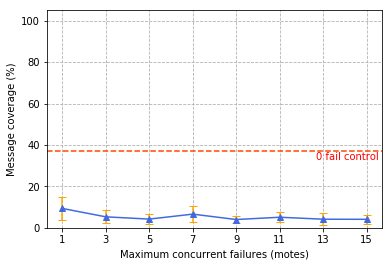

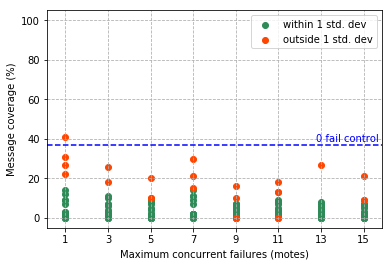

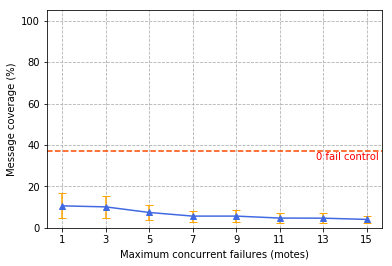

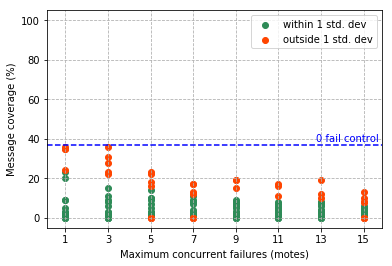

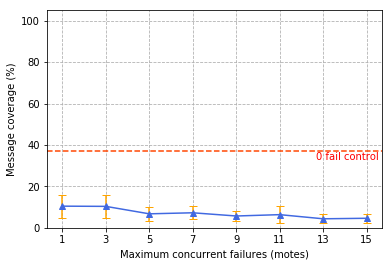

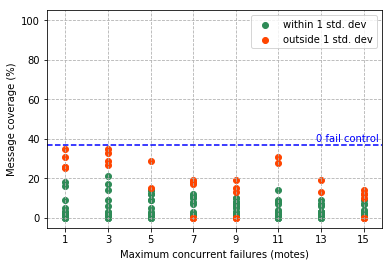

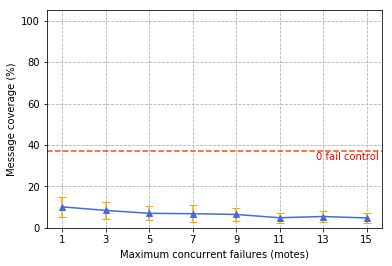

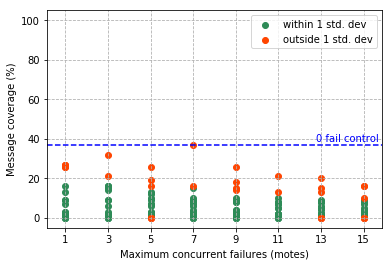

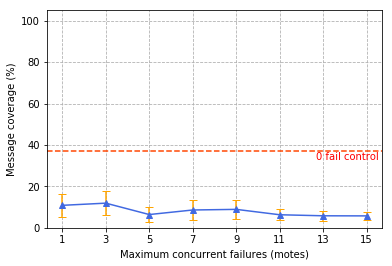

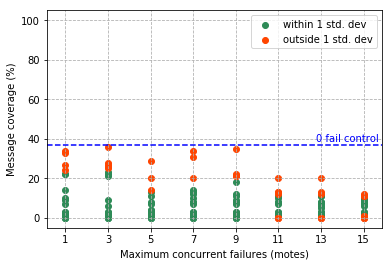

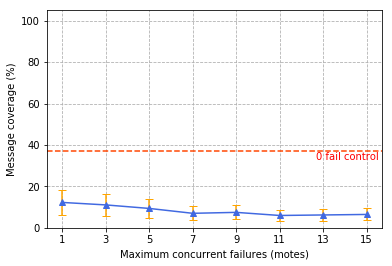

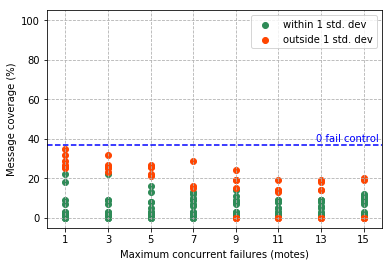

In [21]:
rmh_failure_modes = ('location', 'random')
rmh_conc_failure_range = (1, 3, 5, 7, 9, 11, 13, 15)
rmh_recovery_delay_range = (1, 3, 5, 7, 9, 11, 13, 15)
    
rmh_conc_failure_graphs = list(product(rmh_failure_modes, rmh_conc_failure_range))
rmh_recovery_delay_graphs = list(product(rmh_failure_modes, rmh_recovery_delay_range))

for failure_mode, conc_fails in rmh_conc_failure_graphs:
    graph_filename = f'rmh-coverage-vs-delay-{failure_mode}-n={conc_fails}.eps'
    graph_scatter_filename = f'rmh-coverage-vs-delay-{failure_mode}-n={conc_fails}-scatter.eps'
    graph_file_path = Path(rmh_graphs_dir, graph_filename)
    graph_scatter_file_path = Path(rmh_graphs_dir, graph_scatter_filename)
    
    graph_data('d', 'coverage', rmh_experiments, rmh_control, RmhExperiment, 
               filter_params = {
                   't': failure_mode,
                   'n': conc_fails
               }, xlabel='Mote recovery delay (s)', ylabel='Message coverage (%)',
               control_label='0 fail control', figsize=(6, 4),
               ylim=(0, 105), filename=str(graph_file_path))
    
    graph_data_scatter('d', 'coverage', rmh_experiments, rmh_control, RmhExperiment, 
                       filter_params = {
                           't': failure_mode,
                           'n': conc_fails
                       }, xlabel='Mote recovery delay (s)', ylabel='Message coverage (%)',
                       control_label='0 fail control', figsize=(6, 4), legend_loc='best',
                       ylim=(-5, 105), filename=str(graph_scatter_file_path))
    
for failure_mode, recovery_delay in rmh_recovery_delay_graphs:
    graph_filename = f'rmh-coverage-vs-conc-fails-{failure_mode}-d={recovery_delay}.eps'
    graph_scatter_filename = f'rmh-coverage-vs-conc-fails-{failure_mode}-d={recovery_delay}-scatter.eps'
    graph_file_path = Path(rmh_graphs_dir, graph_filename)
    graph_scatter_file_path = Path(rmh_graphs_dir, graph_scatter_filename)
    
    graph_data('n', 'coverage', rmh_experiments, rmh_control, RmhExperiment, 
               filter_params = {
                   't': failure_mode,
                   'd': recovery_delay
               }, xlabel='Maximum concurrent failures (motes)', ylabel='Message coverage (%)',
               control_label='0 fail control', figsize=(6, 4),
               ylim=(0, 105), filename=str(graph_file_path))
    
    graph_data_scatter('n', 'coverage', rmh_experiments, rmh_control, RmhExperiment, 
                       filter_params = {
                           't': failure_mode,
                           'd': recovery_delay
                       }, xlabel='Maximum concurrent failures (motes)', ylabel='Message coverage (%)',
                       control_label='0 fail control', figsize=(6, 4), legend_loc='best',
                       ylim=(-5, 105), filename=str(graph_scatter_file_path))

# Trickle

In [26]:
Experiment = namedtuple('Experiment', ['d', 'k', 'imin', 'n', 't', 'imax'])

trickle_base_dir = Path('tpwsn-trickle/')
trickle_results_dir = Path(trickle_base_dir, 'results-21x21')
trickle_experiments_path = Path(trickle_base_dir, 'results_data.pickle')
trickle_control_path = Path(trickle_base_dir, 'control_data.pickle')
trickle_graphs_dir = Path('graphs-21x21/trickle/')

trickle_control, trickle_experiments = aggregate_results(trickle_results_dir)

if not trickle_graphs_dir.exists():
    trickle_graphs_dir.mkdir(parents=True, exist_ok=True)
    
# dict([(key, None) for key in Experiment._fields])
trickle_control_key = list(filter_experiments(trickle_control.keys(), Experiment(**{
    'k': 2,
    'imin': 16, 
    'imax': 10, 
    'd': None, 
    'n': None,
    't': None
})))[0]
trickle_control_end_mean, trickle_control_end_ci = mean_confidence_interval(
    [x.get('end_tick') for x in trickle_control[trickle_control_key]])
trickle_control_end_mean/1e6, trickle_control_end_ci/1e6

(123.84916055, 81.92960429279712)

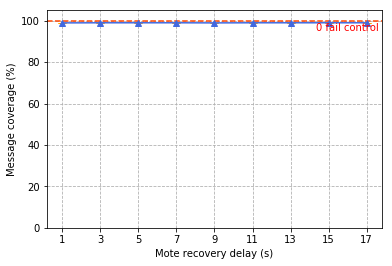

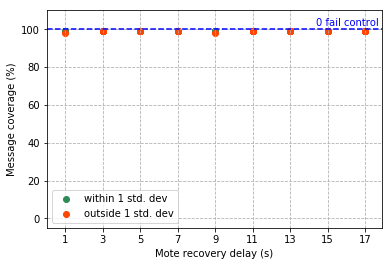

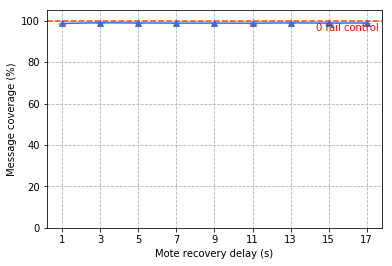

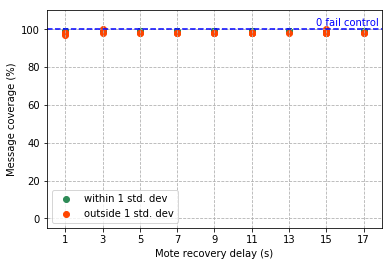

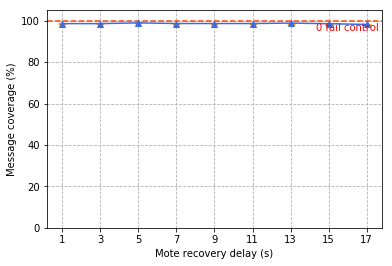

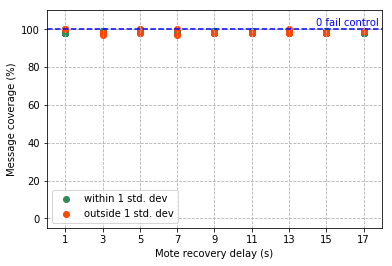

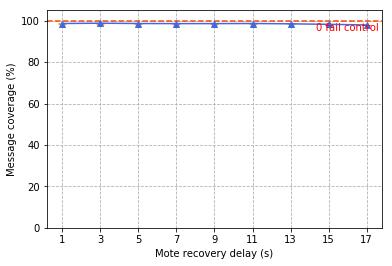

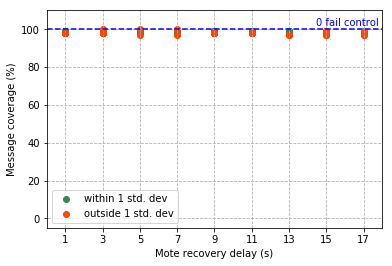

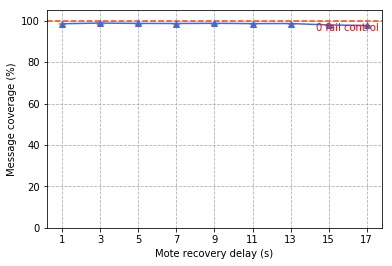

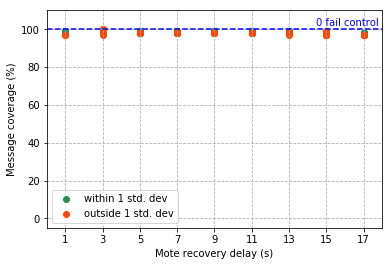

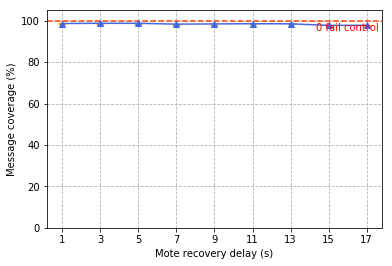

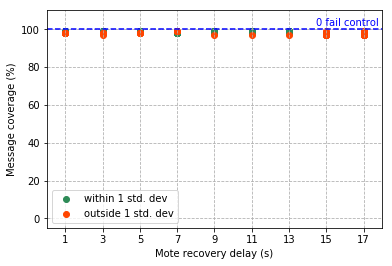

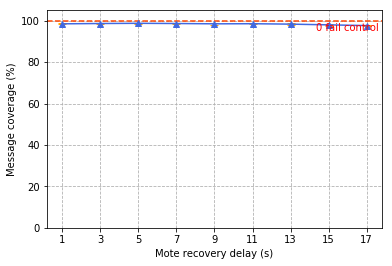

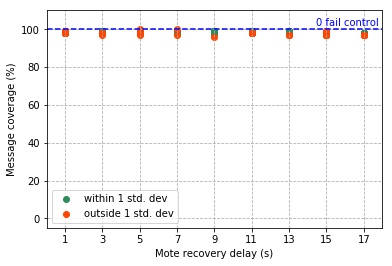

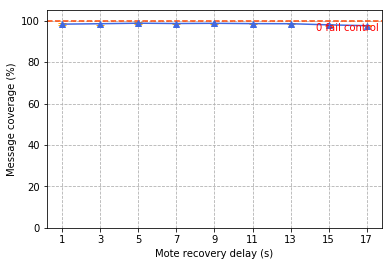

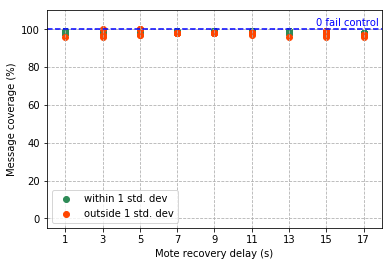

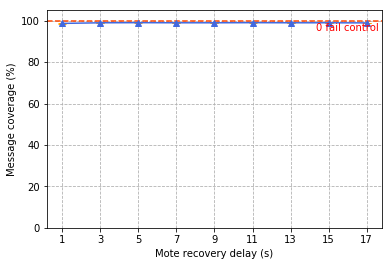

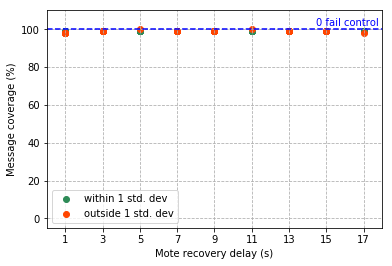

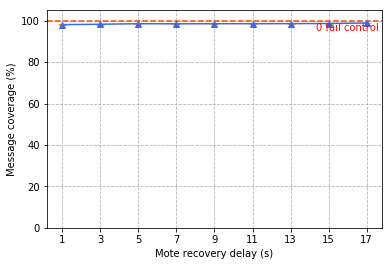

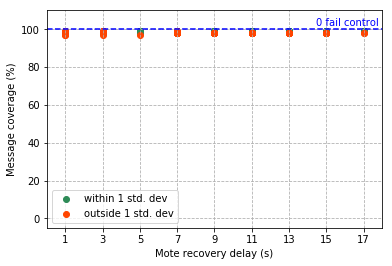

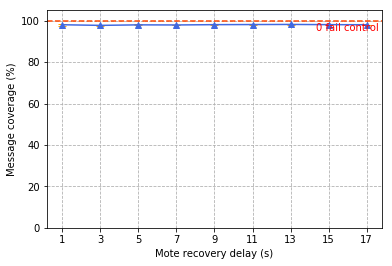

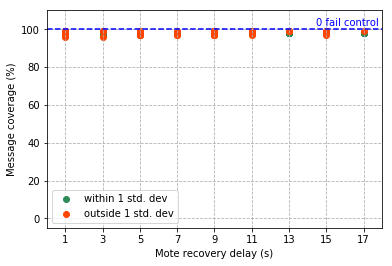

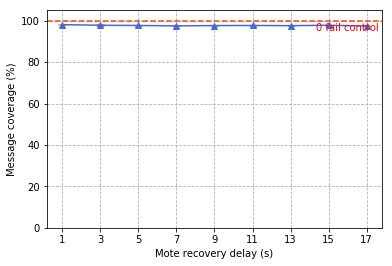

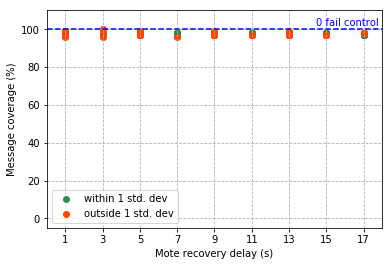

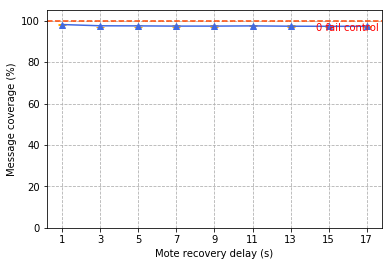

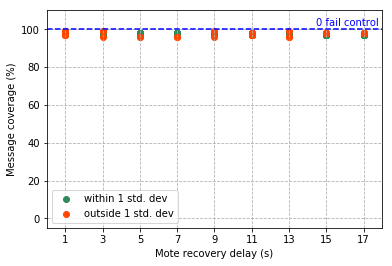

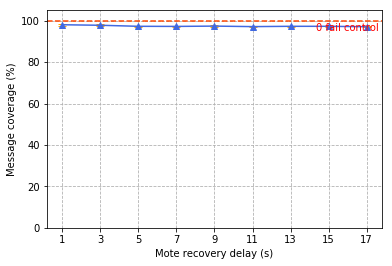

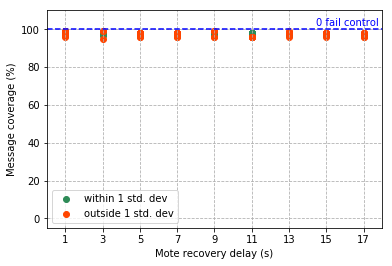

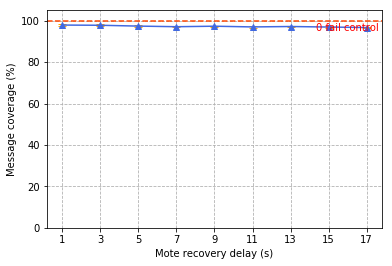

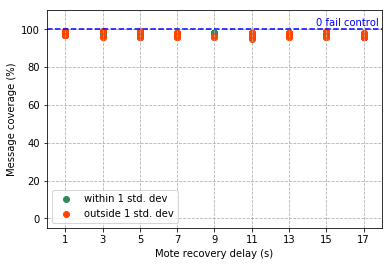

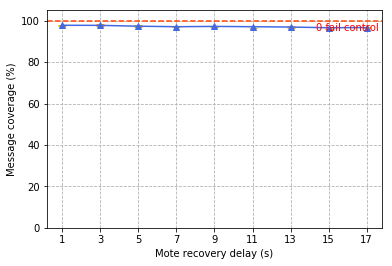

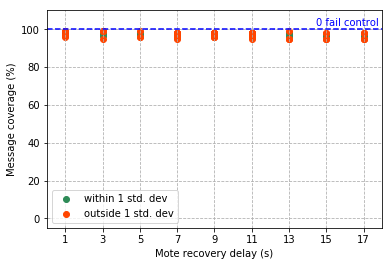

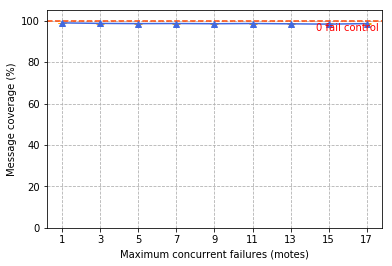

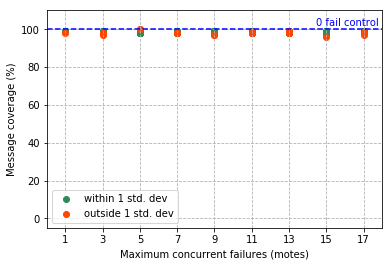

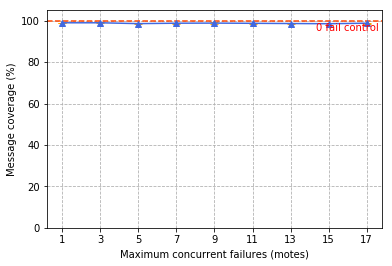

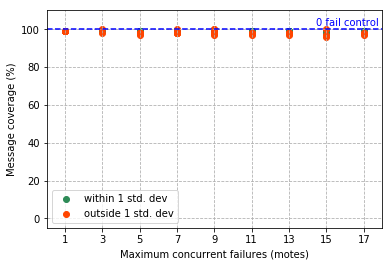

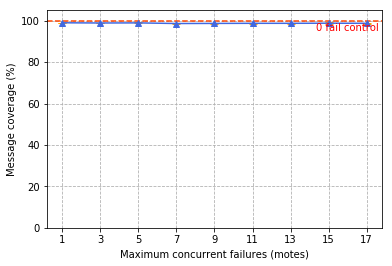

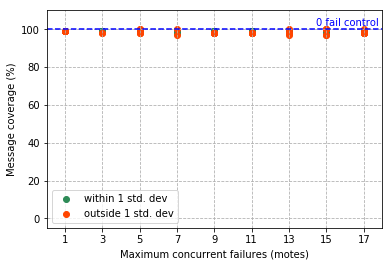

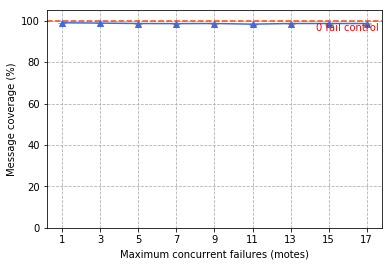

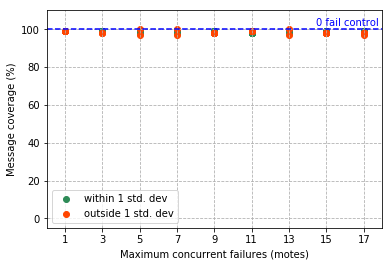

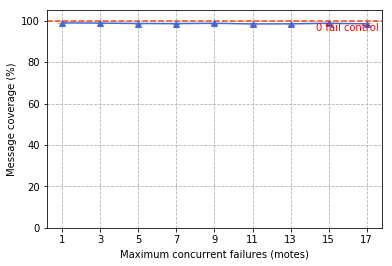

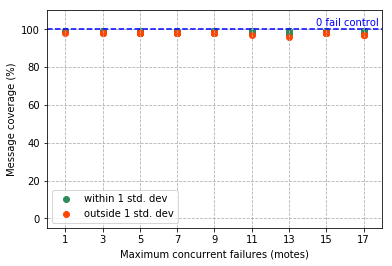

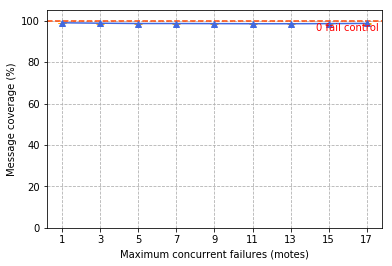

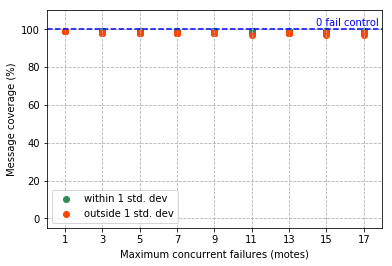

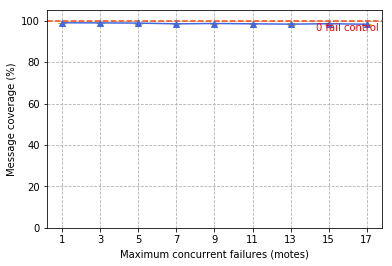

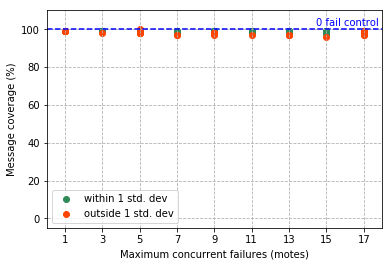

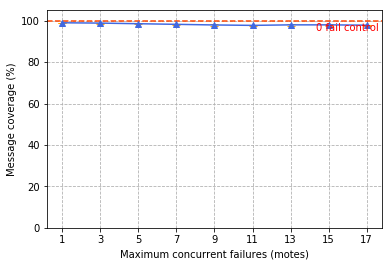

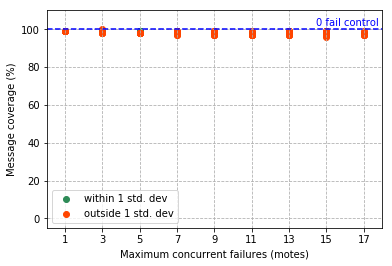

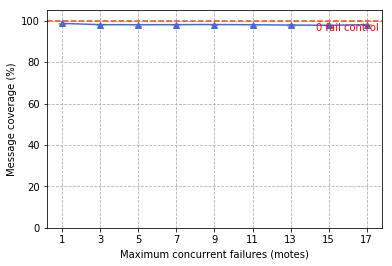

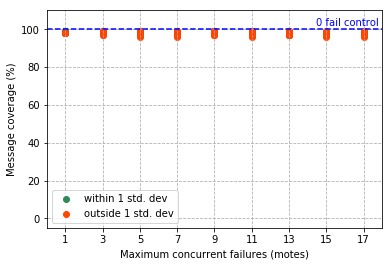

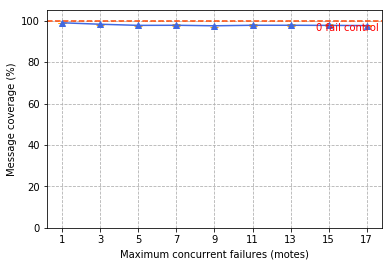

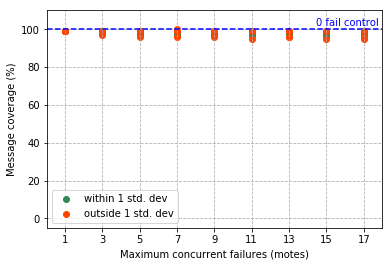

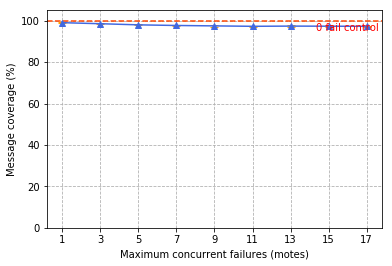

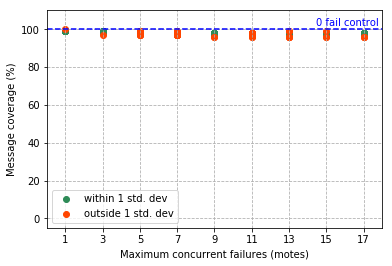

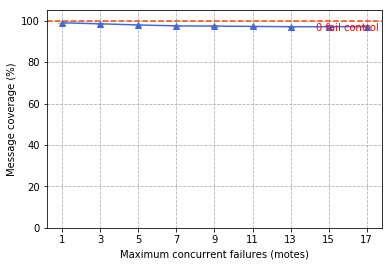

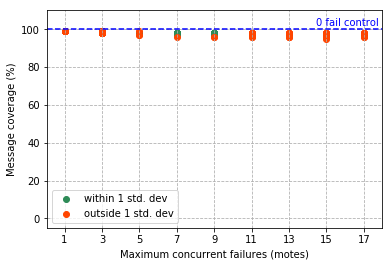

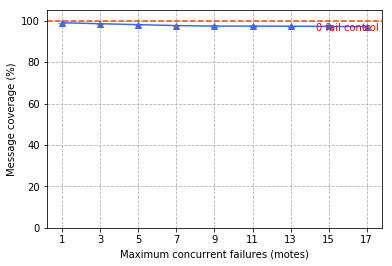

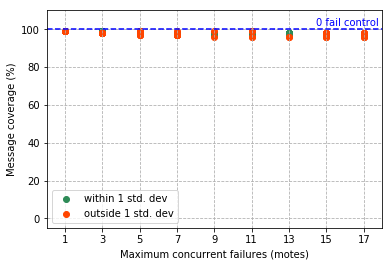

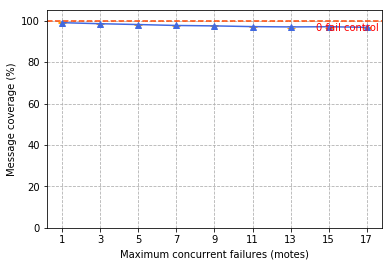

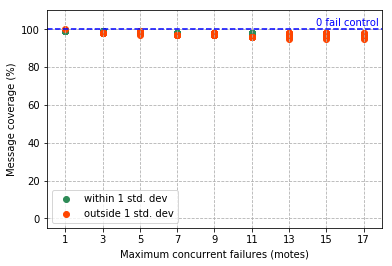

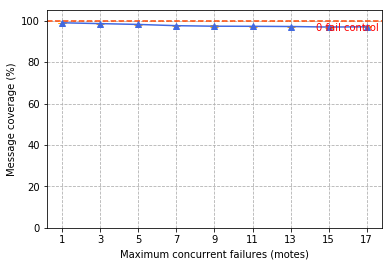

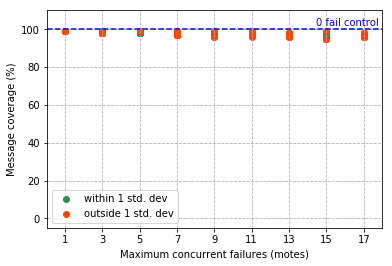

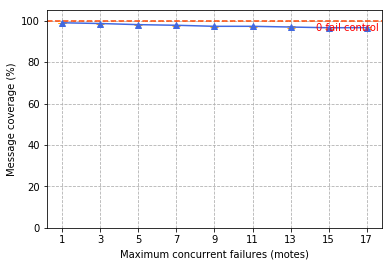

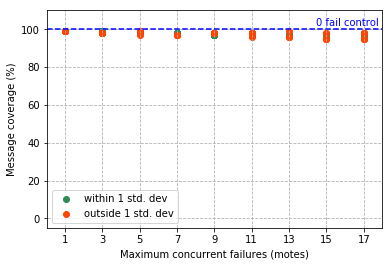

In [27]:
trickle_failure_modes = ('location', 'random')
trickle_conc_failure_range = (1, 3, 5, 7, 9, 11, 13, 15)
trickle_recovery_delay_range = (1, 3, 5, 7, 9, 11, 13, 15)

trickle_conc_failure_graphs = product(trickle_failure_modes, trickle_conc_failure_range)
trickle_recovery_delay_graphs = product(trickle_failure_modes, trickle_recovery_delay_range)

for failure_mode, conc_fails in trickle_conc_failure_graphs:
    graph_filename = f'trickle-coverage-vs-delay-{failure_mode}-n={conc_fails}.eps'
    graph_scatter_filename = f'trickle-coverage-vs-delay-{failure_mode}-n={conc_fails}-scatter.eps'
    graph_file_path = Path(trickle_graphs_dir, graph_filename)
    graph_scatter_file_path = Path(trickle_graphs_dir, graph_scatter_filename)
    
    graph_data('d', 'coverage', trickle_experiments, trickle_control, Experiment, 
               filter_params = {
                   't': failure_mode,
                   'n': conc_fails,
                   'k': 2,
                   'imin': 16,
                   'imax': 10,
               }, xlabel='Mote recovery delay (s)', ylabel='Message coverage (%)',
               control_label='0 fail control', figsize=(6, 4), ylim=(0, 105),
               filename=str(graph_file_path))
    
    graph_data_scatter('d', 'coverage', trickle_experiments, trickle_control, Experiment, 
                       filter_params = {
                           't': failure_mode,
                           'n': conc_fails,
                           'k': 2,
                           'imin': 16,
                           'imax': 10,
                       }, xlabel='Mote recovery delay (s)', ylabel='Message coverage (%)',
                       control_label='0 fail control', figsize=(6, 4), ylim=(-5, 110),
                       filename=str(graph_scatter_file_path), legend_loc='best')
    
for failure_mode, recovery_delay in trickle_recovery_delay_graphs:
    graph_filename = f'trickle-coverage-vs-conc-fails-{failure_mode}-d={recovery_delay}.eps'
    graph_scatter_filename = f'trickle-coverage-vs-conc-fails-{failure_mode}-d={recovery_delay}-scatter.eps'
    graph_file_path = Path(trickle_graphs_dir, graph_filename)
    graph_scatter_file_path = Path(trickle_graphs_dir, graph_scatter_filename)
    
    graph_data('n', 'coverage', trickle_experiments, trickle_control, Experiment, 
               filter_params = {
                   't': failure_mode,
                   'd': recovery_delay,
                   'k': 2,
                   'imin': 16,
                   'imax': 10,
               }, xlabel='Maximum concurrent failures (motes)', ylabel='Message coverage (%)',
               control_label='0 fail control', figsize=(6, 4), ylim=(0, 105),
               filename=str(graph_file_path))
    
    graph_data_scatter('n', 'coverage', trickle_experiments, trickle_control, Experiment, 
                       filter_params = {
                           't': failure_mode,
                           'd': recovery_delay,
                           'k': 2,
                           'imin': 16,
                           'imax': 10,
                       }, xlabel='Maximum concurrent failures (motes)', ylabel='Message coverage (%)',
                       control_label='0 fail control', figsize=(6, 4), ylim=(-5, 110),
                       filename=str(graph_scatter_file_path), legend_loc='best')